In [9]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
import mplfinance as mpf



d:\amdox\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [11]:
# %pip uninstall tensorflow tensorflow-intel protobuf googleapis-common-protos -y
# %pip uninstall prophet fbprophet -y
%pip install prophet==1.1.5 cmdstanpy==1.2.0


  Using cached prophet-1.1.5-py3-none-win_amd64.whl (13.3 MB)
     -------------------------------------- 93.0/93.0 kB 880.8 kB/s eta 0:00:00
  Attempting uninstall: stanio
    Found existing installation: stanio 0.5.1
    Uninstalling stanio-0.5.1:
      Successfully uninstalled stanio-0.5.1
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.3.0
    Uninstalling cmdstanpy-1.3.0:
      Successfully uninstalled cmdstanpy-1.3.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


DATA COLLECTION USING THE BINANCE API

In [105]:
from binance.client import Client

# Public (no API key required for historical data)
client = Client()

# Get historical klines (candlestick data)
symbol = "BTCUSDT"
interval = Client.KLINE_INTERVAL_1DAY
data_time = "7 years ago UTC"
# data_timeperiod = "1 Jan 2020"

klines = client.get_historical_klines(symbol, interval, data_time)

# Convert to DataFrame
columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
           'quote_asset_volume', 'number_of_trades', 
           'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']

df = pd.DataFrame(klines, columns=columns)

df.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1541462400000,6468.99000000,6531.31000000,6445.18000000,6519.11000000,11926.56569900,1541548799999,77336101.18719475,150475,5734.32113100,37189108.73306704,0
1,1541548800000,6522.73000000,6615.15000000,6509.00000000,6578.46000000,14271.59111700,1541635199999,93820576.63463956,151060,7059.08797300,46413326.05582056,0
2,1541635200000,6578.46000000,6594.00000000,6468.22000000,6479.84000000,13259.78928200,1541721599999,86450363.67835226,145405,6370.53125800,41543352.29678714,0
3,1541721600000,6479.84000000,6511.53000000,6391.01000000,6419.99000000,11787.61658300,1541807999999,75997777.50255908,117043,5993.77106200,38655506.51281597,0
4,1541808000000,6419.99000000,6475.55000000,6411.00000000,6433.05000000,7714.82992600,1541894399999,49745307.64123968,97746,3714.13546800,23951565.83481469,0


DATA PREPROCESSSING

In [106]:
df["timestamp"] =  pd.to_datetime(df["timestamp"],unit='ms')
df[["open","high","low","close","volume"]] = df[["open","high","low","close","volume"]].astype(float)
total_Data = len(df)
total_Data

2557

In [107]:
modified_data = df.replace(0,np.nan)
modified_data.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2018-11-06,6468.99,6531.31,6445.18,6519.11,11926.565699,1541548799999,77336101.18719475,150475,5734.32113100,37189108.73306704,0
1,2018-11-07,6522.73,6615.15,6509.00,6578.46,14271.591117,1541635199999,93820576.63463956,151060,7059.08797300,46413326.05582056,0
2,2018-11-08,6578.46,6594.00,6468.22,6479.84,13259.789282,1541721599999,86450363.67835226,145405,6370.53125800,41543352.29678714,0
3,2018-11-09,6479.84,6511.53,6391.01,6419.99,11787.616583,1541807999999,75997777.50255908,117043,5993.77106200,38655506.51281597,0
4,2018-11-10,6419.99,6475.55,6411.00,6433.05,7714.829926,1541894399999,49745307.64123968,97746,3714.13546800,23951565.83481469,0


In [108]:
df.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2018-11-06,6468.99,6531.31,6445.18,6519.11,11926.565699,1541548799999,77336101.18719475,150475,5734.32113100,37189108.73306704,0
1,2018-11-07,6522.73,6615.15,6509.00,6578.46,14271.591117,1541635199999,93820576.63463956,151060,7059.08797300,46413326.05582056,0
2,2018-11-08,6578.46,6594.00,6468.22,6479.84,13259.789282,1541721599999,86450363.67835226,145405,6370.53125800,41543352.29678714,0
3,2018-11-09,6479.84,6511.53,6391.01,6419.99,11787.616583,1541807999999,75997777.50255908,117043,5993.77106200,38655506.51281597,0
4,2018-11-10,6419.99,6475.55,6411.00,6433.05,7714.829926,1541894399999,49745307.64123968,97746,3714.13546800,23951565.83481469,0


In [109]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'ignore'],
      dtype='object')

In [47]:
# df.drop(columns=['ignore'], inplace=True)
# df.head()
# df = df[df[['open','high','low','close','volume']].ne(0).all(axis=1)]
# len(df)

df.describe()
# df.head()
# df.info()
df.columns
df.isnull().sum()
df.shape
# df.value_counts().values
# data=df.set_index('timestamp') # set index
# df_reset = df_indexed.reset_index()  # reset the index




(2557, 11)

In [48]:
# REMOVING IGNORE COLUMN BECAUSE ITS FULL OF ZERO, SO IT WOULD AFFECT 
# data= df.drop(columns=['ignore'], inplace=True
data = df


In [49]:
data.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2018-11-06,6468.99,6531.31,6445.18,6519.11,11926.565699,1541548799999,77336101.18719475,150475,5734.32113100,37189108.73306704
1,2018-11-07,6522.73,6615.15,6509.00,6578.46,14271.591117,1541635199999,93820576.63463956,151060,7059.08797300,46413326.05582056
2,2018-11-08,6578.46,6594.00,6468.22,6479.84,13259.789282,1541721599999,86450363.67835226,145405,6370.53125800,41543352.29678714
3,2018-11-09,6479.84,6511.53,6391.01,6419.99,11787.616583,1541807999999,75997777.50255908,117043,5993.77106200,38655506.51281597
4,2018-11-10,6419.99,6475.55,6411.00,6433.05,7714.829926,1541894399999,49745307.64123968,97746,3714.13546800,23951565.83481469


In [50]:
data.describe()

,timestamp,open,high,low,close,volume,close_time,number_of_trades
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2.557000e+03,2.557000e+03
mean,2022-05-07 00:00:00,39557.005068,40390.260055,38672.537786,39594.385585,69956.782795,1.651968e+12,2.096801e+06
min,2018-11-06 00:00:00,3211.710000,3276.500000,3156.260000,3211.720000,3282.173520,1.541549e+12,9.774600e+04
25%,2020-08-06 00:00:00,10940.000000,11342.820000,10723.000000,10954.010000,27609.873795,1.596758e+12,6.797210e+05
50%,2022-05-07 00:00:00,30077.400000,30595.000000,29482.610000,30083.750000,43943.889026,1.651968e+12,1.338533e+06
75%,2024-02-05 00:00:00,58683.390000,59845.000000,57128.000000,58712.590000,74261.932842,1.707178e+12,2.573906e+06
max,2025-11-05 00:00:00,124658.540000,126199.630000,123084.000000,124658.540000,760705.362783,1.762387e+12,1.522359e+07
std,NaN,31806.348125,32319.425842,31260.342235,31823.541611,81633.125661,6.378797e+10,2.194466e+06


In [ ]:
# data = data.to_csv(r"D:\amdox\data_with_index.csv") /// changed data to verify the progress 

In [74]:
data.head()
data=data.reset_index()


EDA PROCESS


Closing price trend line - done 
Candle stick chart - to compare open, high, low, close  --->done
Volume trend chart - x axis -date , y axis - volume --->done
Correlation heatmap we already did  ------> done


Seasonal decomposition 

Seasonal decomposition = seasonal_decompose(df['close'], model='additive', period=30)
decomposition.plot()
plt.show()

voltality(daily returns and moving avgs)

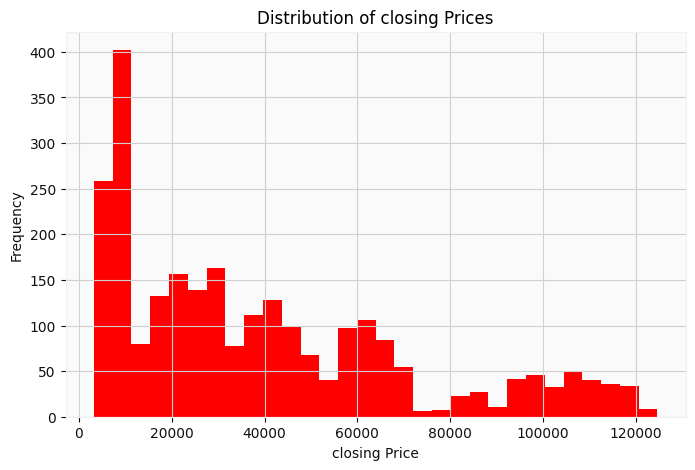

In [141]:
# distribution of closing price
plt.figure(figsize=(8,5))
plt.hist(data['close'], bins=30,color="red")
plt.title("Distribution of closing Prices")
plt.xlabel("closing Price")
plt.ylabel("Frequency")
plt.show()

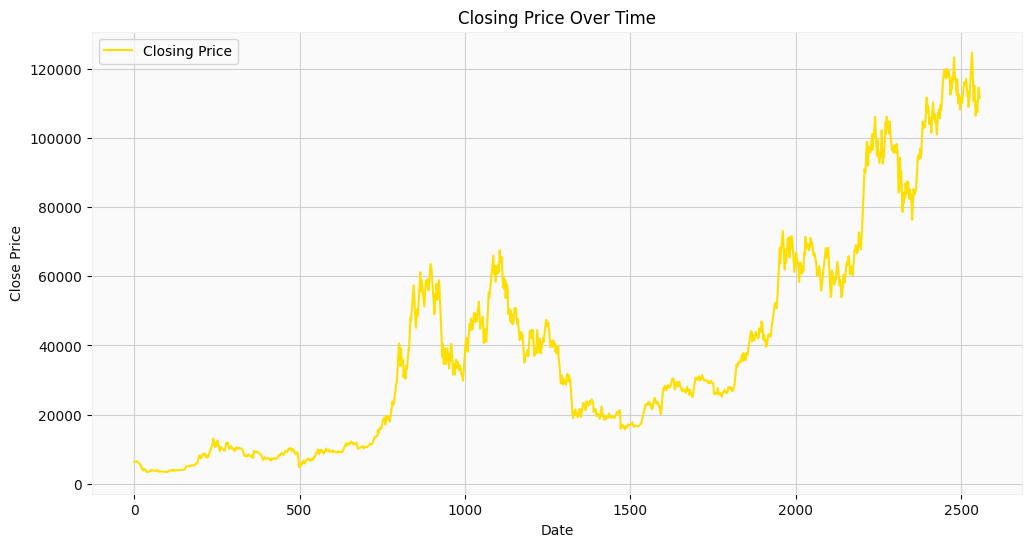

In [146]:
# Closing Price Trend
plt.figure(figsize=(12,6))
plt.plot(data['close'], label='Closing Price', color='#FFDF00')
plt.title("Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
# plt.grid("False")
plt.show()

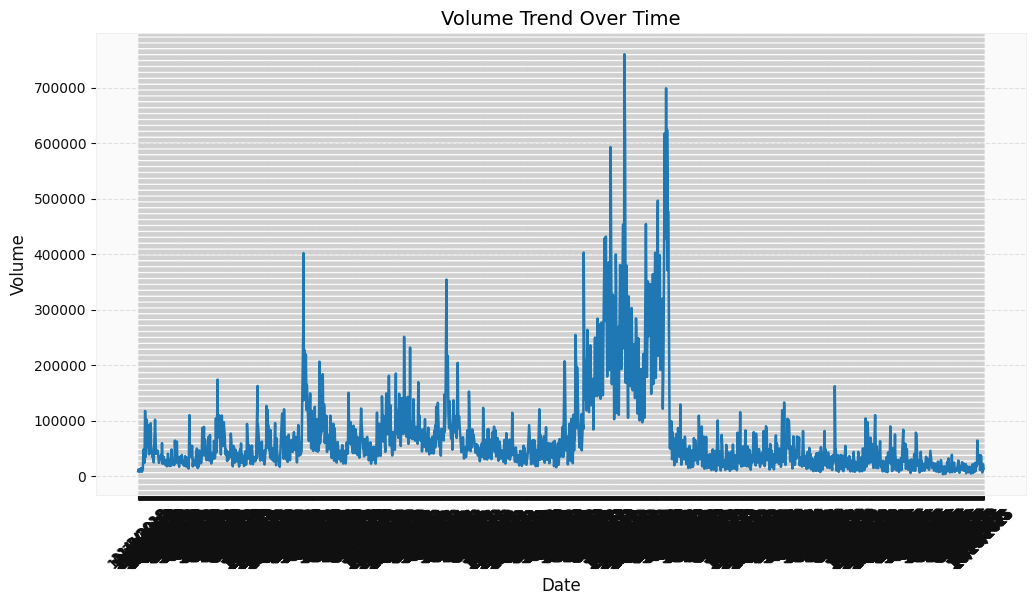

In [142]:
# Volume trend chart

plt.figure(figsize=(12,6))
plt.plot(data['timestamp'], data['volume'], linewidth=1.8)

# Add title and labels
plt.title("Volume Trend Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume", fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show grid for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

d:\amdox\venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


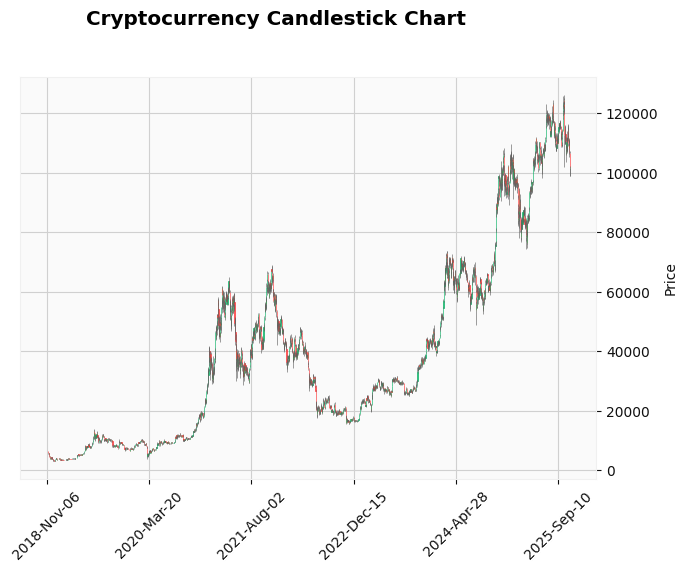

In [89]:
# df.set_index('timestamp', inplace=True)

# Keep only OHLC (and volume if available)
candlestick_df = df[['open', 'high', 'low', 'close', 'volume']]

# Plot candlestick chart
mpf.plot(candlestick_df,
         type='candle',
         style='yahoo',        # you can change style : binance, charles, nightclouds, etc.
         title='Cryptocurrency Candlestick Chart',
         ylabel='Price',
         volume=False)          # Set to False if you don't want volume bars



d:\amdox\venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


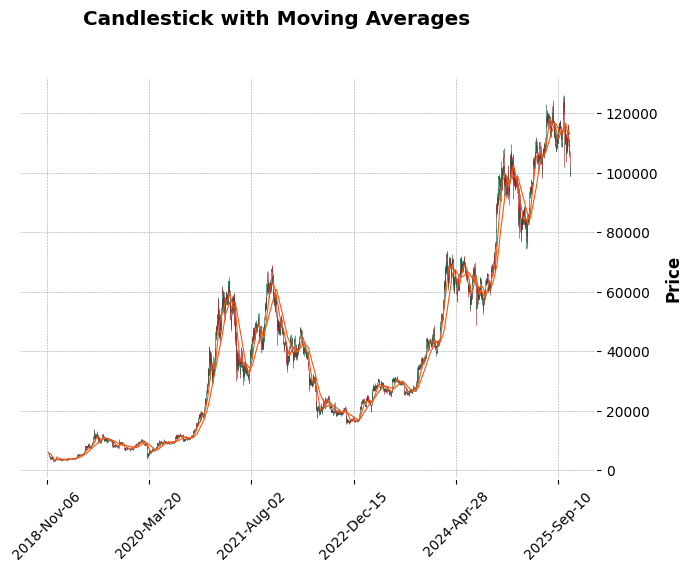

In [63]:
# CANDLESTICK - II FOR MOVING AVGS.

mpf.plot(candlestick_df,
         type='candle',
         style='charles',
         mav=(20,50),         # 20-day and 50-day moving averages
         volume=False,
         title='Candlestick with Moving Averages')

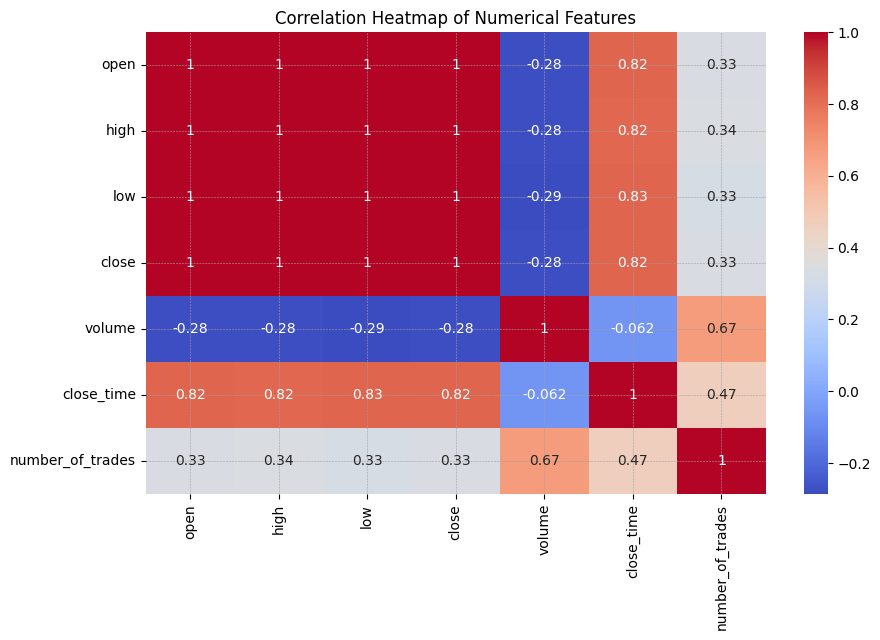

In [62]:
# CORRELATION HEATMAP

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()


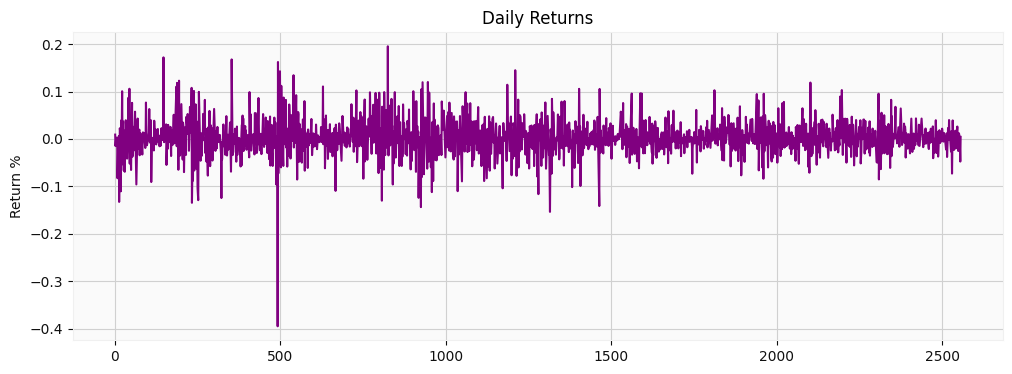

In [82]:
# volatility(daily returns)

data['daily_return'] = data['close'].pct_change()

plt.figure(figsize=(12,4))
plt.plot(data['daily_return'], color='purple')
plt.title("Daily Returns")
plt.ylabel("Return %")
plt.show()


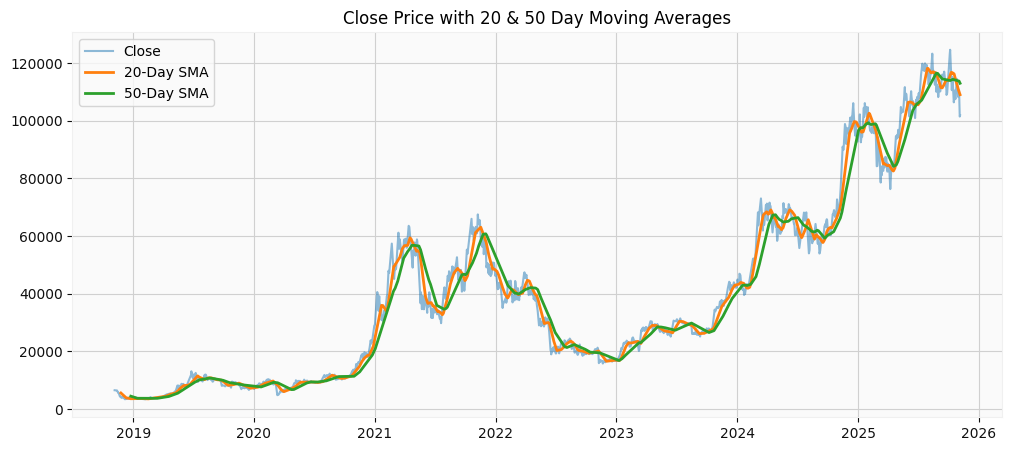

In [85]:
#  Moving average(SMA 20 AND SMA50)

df['SMA20'] = df['close'].rolling(window=20).mean()
df['SMA50'] = df['close'].rolling(window=50).mean()

plt.figure(figsize=(12,5))
plt.plot(df['close'], label='Close', alpha=0.5)
plt.plot(df['SMA20'], label='20-Day SMA', linewidth=2)
plt.plot(df['SMA50'], label='50-Day SMA', linewidth=2)
plt.title("Close Price with 20 & 50 Day Moving Averages")
plt.legend()
plt.show()


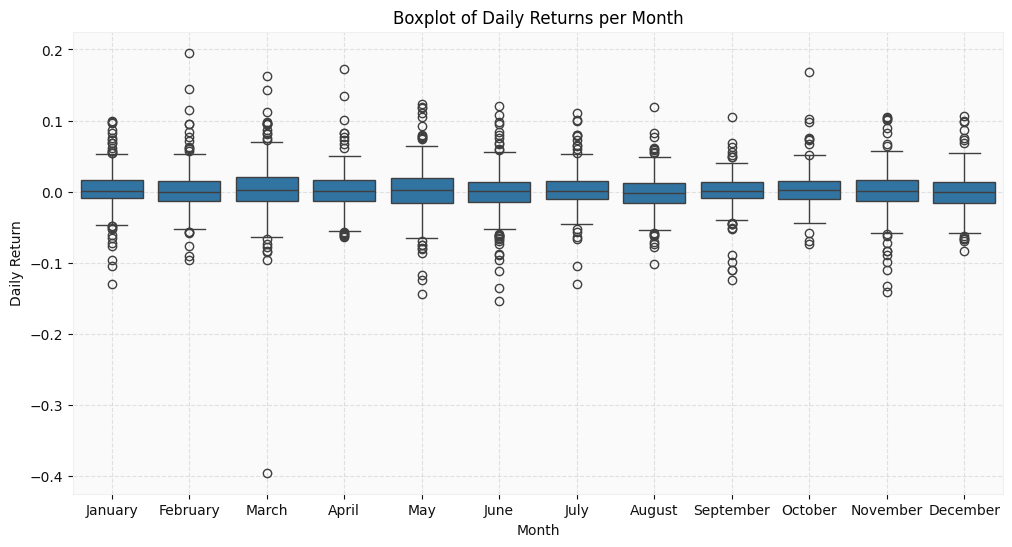

In [148]:
# BOX PLOT OF DAILY RETURNS PER MONTH

# Ensure timestamp is in datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Calculate Daily Returns
data['daily_return'] = data['close'].pct_change()

# Extract Month Name
data['Month'] = data['timestamp'].dt.month_name()

# Drop NaN values created from pct_change()
data = data.dropna(subset=['daily_return'])

# Define correct month order
month_order = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]

# Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='daily_return', data=data, order=month_order)

plt.title("Boxplot of Daily Returns per Month")
plt.xlabel("Month")
plt.ylabel("Daily Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


FORECASTING MODEL

In [ ]:
def evaluate_model(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    print(f"\n{model_name} Performance:")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R2_score:{r2:.4f}")



In [149]:
# data.tail()

In [ ]:
data = pd.read_csv(r"D:\amdox\binance_crypto_data_file.csv")  # everytime run the data while using models

18:01:56 - cmdstanpy - INFO - Chain [1] start processing
18:01:58 - cmdstanpy - INFO - Chain [1] done processing


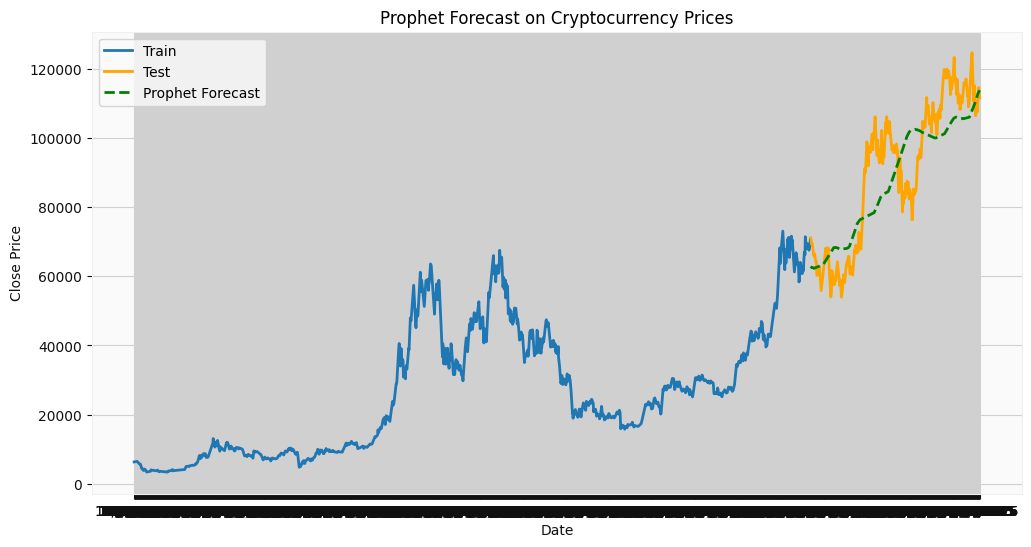


Prophet Performance:
MAE  : 9520.6125
RMSE : 11219.5061
MAPE : 10.71%
R2_score:0.7001


In [119]:
# prophet model

# Prepare data for Prophet
df = data[['timestamp', 'close']].rename(columns={'timestamp': 'ds', 'close': 'y'})

# Split into train & test
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Build & train model
model = Prophet()
model.fit(train)

# Forecast for the same length as the test set
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)

# Extract predictions
prophet_pred = forecast['yhat'][-len(test):].values

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(train['ds'], train['y'], label='Train', linewidth=2)
plt.plot(test['ds'], test['y'], label='Test', color='orange', linewidth=2)
plt.plot(test['ds'], prophet_pred, label='Prophet Forecast', color='green', linestyle='--', linewidth=2)
plt.legend()
plt.title("Prophet Forecast on Cryptocurrency Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

#Evaluate prophet evaluation 
evaluate_model(test['y'], prophet_pred, "Prophet")



d:\amdox\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\amdox\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\amdox\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


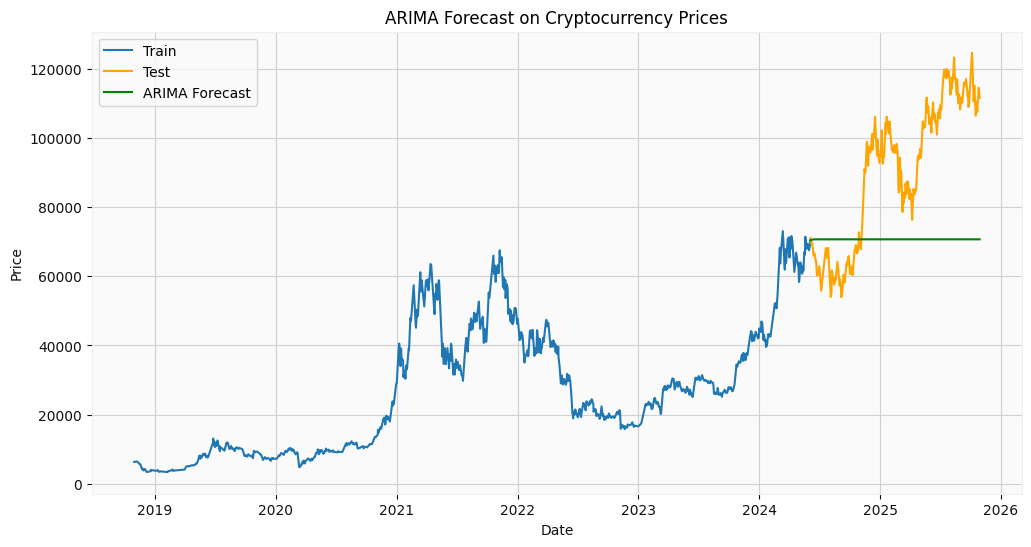


ARIMA Performance:
MAE  : 24260.3403
RMSE : 28347.6511
MAPE : 24.70%
R2_score:-0.9144


In [121]:
# ARIMA MODEL

# Convert timestamp column to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values(by='timestamp')

# Use closing price for time series
data.set_index('timestamp', inplace=True)
data = data[['close']].rename(columns={'close': 'price'})

# Split train and test (80%-20%)
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Build ARIMA model
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

# Forecast for test period
arima_pred = arima_fit.forecast(steps=len(test))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(train.index, train['price'], label='Train')
plt.plot(test.index, test['price'], label='Test', color='orange')
plt.plot(test.index, arima_pred, label='ARIMA Forecast', color='green')
plt.legend()
plt.title("ARIMA Forecast on Cryptocurrency Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

evaluate_model(test['price'], arima_pred, "ARIMA")


d:\amdox\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 0.0036
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.0354e-04
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 4.7515e-04
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 4.6820e-04
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.9151e-04
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.6049e-04
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.2379e-04
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.4552e-04
Epoch 9/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.7925e-04
Epoch 10/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.7838e-04
Epoch 11/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.6766e-04
Epoch 12/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.4264e-04
Epoch 13/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.1526e-04
Epoch 14/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 2.2178e-04
Epoch 15/25
63/63 ━

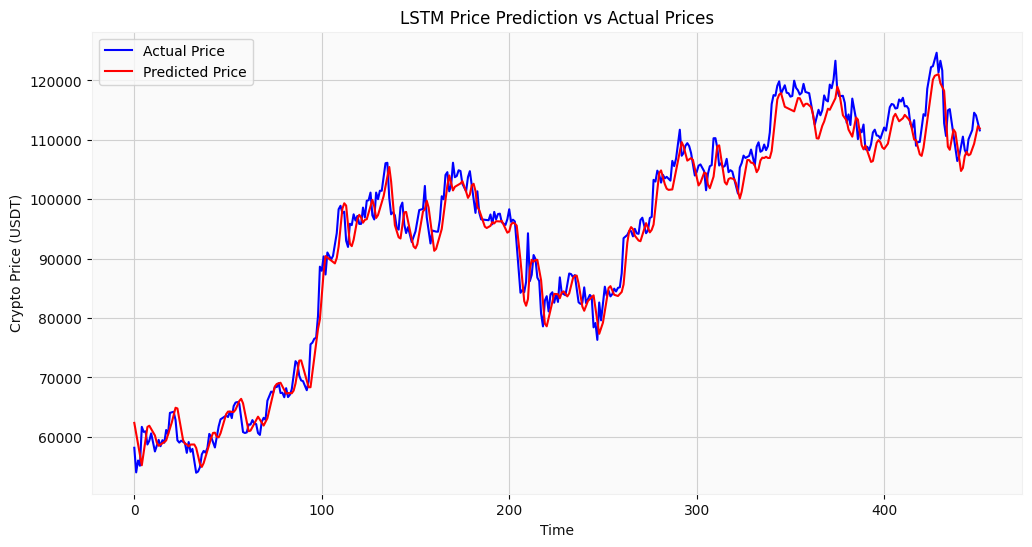


LSTM Performance:
MAE  : 2264.4019
RMSE : 2844.7979
MAPE : 2.45%
R2_score:0.9781


In [125]:
# LSTM  MODEL
prices = data['close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)


# Step 4️⃣: Create training and testing datasets

training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_size]
test_data = scaled_data[training_size:]


# Step 5️⃣: Create time-step sequences for LSTM
# (Using 60 previous days to predict next day)

def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, 60)
X_test, y_test = create_dataset(test_data, 60)


# Step 6️⃣: Reshape data to fit LSTM input [samples, time_steps, features]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Step 7️⃣: Build LSTM Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')


# Step 8️⃣: Train the model

history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)


# Step 9️⃣: Predict using the model

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to actual scale
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


# Step 1️⃣1️⃣: Plot predictions vs actual prices

plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title("LSTM Price Prediction vs Actual Prices")
plt.xlabel("Time")
plt.ylabel("Crypto Price (USDT)")
plt.legend()
plt.show()

evaluate_model(actual_prices, predictions, "LSTM")



In [132]:
data.head()
data=data.reset_index()

d:\amdox\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\amdox\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
d:\amdox\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


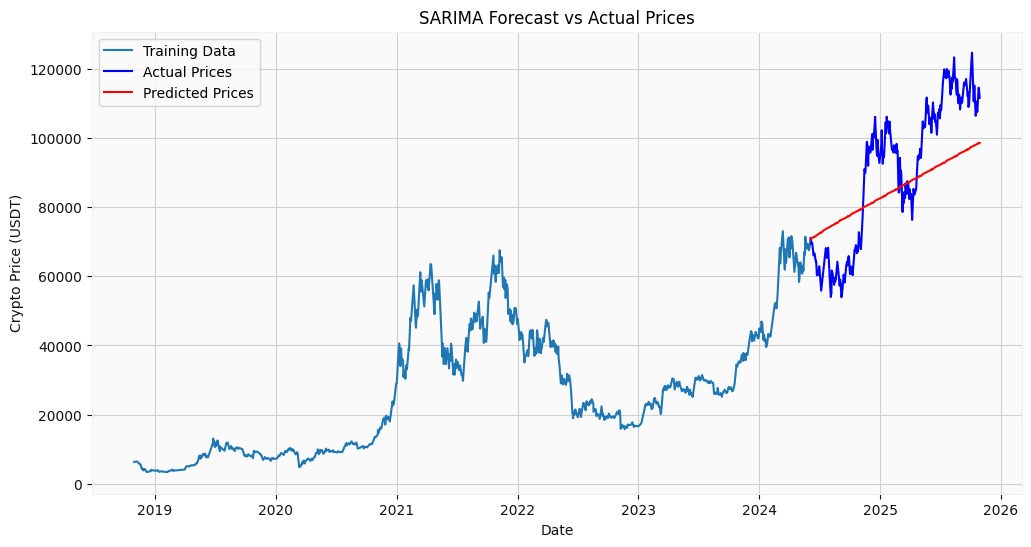


SARIMA Performance:
MAE  : 13460.5250
RMSE : 14834.7536
MAPE : 15.25%
R2_score:0.4757


In [133]:
# SARIMA MODEL
# Convert timestamp to datetime and set as index
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values('timestamp')
data.set_index('timestamp', inplace=True)

# Use only 'close' price for analysis
prices = data['close']
train_size = int(len(prices) * 0.8)
train, test = prices.iloc[:train_size], prices.iloc[train_size:]

# Step 3️⃣: Build and fit SARIMA model

# Parameters (p,d,q)(P,D,Q,s)
# p,d,q = ARIMA order; P,D,Q,s = seasonal order (s = season length)
model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
sarima_model = model.fit(disp=False)

# Step 4️⃣: Forecast future values
forecast = sarima_model.predict(start=len(train), end=len(prices)-1, dynamic=False)
# Step 6️⃣: Plot actual vs forecasted prices
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Prices', color='blue')
plt.plot(test.index, forecast, label='Predicted Prices', color='red')
plt.title("SARIMA Forecast vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Crypto Price (USDT)")
plt.legend()
plt.grid(True)
plt.show()

evaluate_model(test, forecast, "SARIMA")

